In [16]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from numpy.polynomial.hermite import hermgauss
from numpy.polynomial.laguerre import laggauss

**Problem 5.1.1**

In [17]:
def f(x):
    return 1.0/math.sqrt(x*x + 1.0)

analytic = math.asinh(1) - math.asinh(-1)

def composite_midpoint(f, a, b, n):
    h = (b-a)/n
    s = 0.0
    for i in range(n):
        left = a + i*h
        right = left + h
        mid = 0.5*(left+right)
        s += f(mid)
    return h*s

def composite_left(f, a, b, n):
    h = (b-a)/n
    s = 0.0
    for i in range(n):
        s += f(a + i*h)
    return h*s

def composite_right(f, a, b, n):
    h = (b-a)/n
    s = 0.0
    for i in range(1,n+1):
        s += f(a + i*h)
    return h*s

def composite_trap(f, a, b, n):
    h = (b-a)/n
    s = 0.5*(f(a)+f(b))
    for i in range(1,n):
        s += f(a + i*h)
    return h*s

a, b = -1.0, 1.0
n = 51
mid = composite_midpoint(f, a, b, n)
left = composite_left(f, a, b, n)
right = composite_right(f, a, b, n)
trap = composite_trap(f, a, b, n)

print(f"Analytic = {analytic:.15f}")
print(f"Midpoint (n={n}) = {mid:.15f}, error = {abs(mid-analytic):.3e}")
print(f"Left endpoint  = {left:.15f}, error = {abs(left-analytic):.3e}")
print(f"Right endpoint = {right:.15f}, error = {abs(right-analytic):.3e}")
print(f"Trapezoid      = {trap:.15f}, error = {abs(trap-analytic):.3e}")

Analytic = 1.762747174039086
Midpoint (n=51) = 1.762792485492911, error = 4.531e-05
Left endpoint  = 1.762656552436679, error = 9.062e-05
Right endpoint = 1.762656552436679, error = 9.062e-05
Trapezoid      = 1.762656552436679, error = 9.062e-05


**Problem 5.1.2**

Total unique f evaluations: 108301


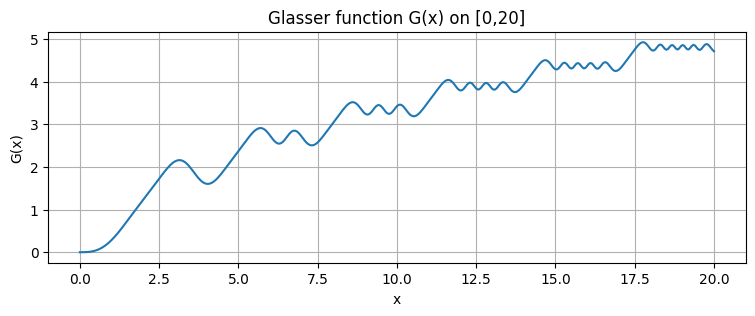

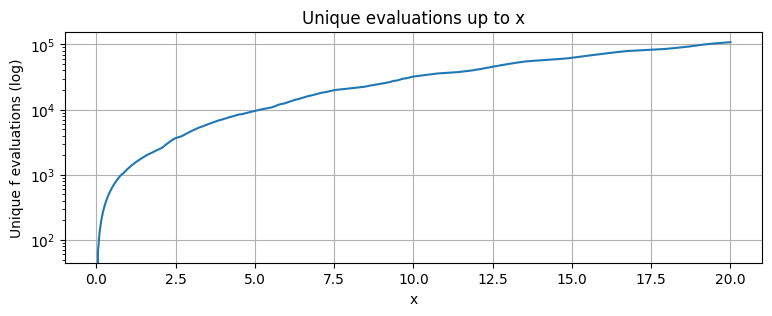

First 20 minima (x):
 1: 4.034236247386
 2: 6.283185307180
 3: 7.316132286080
 4: 9.071122903755
 5: 9.752749948043
 6: 10.532772330990
 7: 12.016125582915
 8: 12.566370614359
 9: 13.067947608128
10: 13.723563264695
11: 15.030194808961
12: 15.503918154781
13: 15.906770647826
14: 16.323474170857
15: 16.900804141024
16: 18.081137558264
17: 18.503091015058
18: 18.849555921539
19: 19.183249387453
20: 19.547774658155


In [ ]:
def adaptive_simpson(f, a, b, eps, cache=None, maxrecursion=50):
    if cache is None:
        cache = {}
    eval_count = 0
    def f_cached(x):
        nonlocal eval_count
        if x in cache:
            return cache[x]
        fx = f(x)
        cache[x] = fx
        eval_count += 1
        return fx
    def simpson(a,b,fa,fm,fb):
        return (b-a)*(fa + 4*fm + fb)/6.0
    fa = f_cached(a); fb = f_cached(b); m = 0.5*(a+b); fm = f_cached(m)
    S = simpson(a,b,fa,fm,fb)
    def recurse(a,b,fa,fm,fb,S,eps,depth):
        nonlocal eval_count
        m = 0.5*(a+b)
        lm = 0.5*(a+m); rm = 0.5*(m+b)
        flm = f_cached(lm); frm = f_cached(rm)
        Sleft = simpson(a,m,fa,flm,fm)
        Sright = simpson(m,b,fm,frm,fb)
        S2 = Sleft + Sright
        if depth <= 0 or abs(S2 - S) <= 15*eps:
            return S2 + (S2 - S)/15.0
        left = recurse(a,m,fa,flm,fm,Sleft,eps/2.0,depth-1)
        right = recurse(m,b,fm,frm,fb,Sright,eps/2.0,depth-1)
        return left + right
    I = recurse(a,b,fa,fm,fb,S,eps,maxrecursion)
    return I, eval_count, cache

def integrand(t):
    return math.sin(t * math.sin(t))

x_grid = np.linspace(0,20,401)
tol = 1e-12
G_vals = np.zeros_like(x_grid)
eval_counts = np.zeros_like(x_grid, dtype=int)

cache = {}
G_current = 0.0
G_vals[0] = 0.0
eval_counts[0] = 0

for i in range(1,len(x_grid)):
    a = x_grid[i-1]; b = x_grid[i]
    dx = b - a
    eps_interval = tol * (dx / (x_grid[-1] - x_grid[0]))
    I, new_evals, cache = adaptive_simpson(integrand, a, b, eps_interval, cache=cache)
    G_current += I
    G_vals[i] = G_current
    eval_counts[i] = len(cache)

print('Total unique f evaluations:', len(cache))

plt.figure(figsize=(9,3))
plt.plot(x_grid, G_vals)
plt.xlabel('x'); plt.ylabel('G(x)'); plt.title('Glasser function G(x) on [0,20]'); plt.grid(True)
plt.show()

plt.figure(figsize=(9,3))
plt.semilogy(x_grid, eval_counts)
plt.xlabel('x'); plt.ylabel('Unique f evaluations (log)'); plt.title('Unique evaluations up to x'); plt.grid(True)
plt.show()

def Gprime(x): return math.sin(x * math.sin(x))
def Gpp(x): return math.cos(x*math.sin(x))*(math.sin(x) + x*math.cos(x))

scan_x = np.linspace(1e-6, 50.0, 50001)
scan_vals = np.array([Gprime(x) for x in scan_x])
roots = []
for i in range(len(scan_x)-1):
    v1 = scan_vals[i]; v2 = scan_vals[i+1]
    if v1 == 0:
        roots.append(scan_x[i])
    elif v1 * v2 < 0:
        a = scan_x[i]; b = scan_x[i+1]; fa = v1; fb = v2
        for _ in range(50):
            m = 0.5*(a+b); fm = Gprime(m)
            if fa * fm <= 0:
                b = m; fb = fm
            else:
                a = m; fa = fm
        roots.append(0.5*(a+b))
    if len(roots) > 400:
        break

minima = [r for r in roots if r > 0 and Gpp(r) > 0]
minima20 = minima[:20]
print("First 20 minima (x):")
for i,x in enumerate(minima20, start=1):
    print(f"{i:2d}: {x:.12f}")

**Problem 5.1.3**

In [ ]:
def hermite_and_derivative(n, x):
    if n == 0:
        return 1.0, 0.0
    H0 = 1.0
    H1 = 2.0 * x
    if n == 1:
        return H1, 2.0
    Hnm2 = H0; Hnm1 = H1
    for k in range(2, n+1):
        Hn = 2*x*Hnm1 - 2*(k-1)*Hnm2
        Hnm2, Hnm1 = Hnm1, Hn
    Hprime = 2*n * Hnm2
    return Hnm1, Hprime

def hermite_roots(n, tol=1e-14, maxiter=100):
    roots = np.zeros(n)
    for j in range(1, n+1):
        guess = np.sqrt(2*n + 1) * np.cos((4*j - 1) * np.pi / (4*n + 2))
        x = guess
        for _ in range(maxiter):
            H, Hp = hermite_and_derivative(n, x)
            dx = -H / Hp
            x += dx
            if abs(dx) < tol:
                break
        roots[j-1] = x
    return np.sort(roots)

def gauss_hermite(n):
    xs = hermite_roots(n)
    cs = np.zeros_like(xs)
    for i, x in enumerate(xs):
        _, Hprime = hermite_and_derivative(n, x)
        cs[i] = (2**(n+1) * math.factorial(n) * math.sqrt(math.pi)) / (Hprime**2)
    return xs, cs

for n in [2,4,8,12,16,20]:
    xs, cs = gauss_hermite(n)
    xn, cn = hermgauss(n)
    dx = np.max(np.abs(xs - xn))
    dw = np.max(np.abs(cs - cn))
    print(f"n={n}: max |x - x_np| = {dx:.3e}, max |c - c_np| = {dw:.3e}")

n=2: max |x - x_np| = 0.000e+00, max |c - c_np| = 2.220e-16
n=4: max |x - x_np| = 2.220e-16, max |c - c_np| = 1.110e-16
n=8: max |x - x_np| = 9.490e-01, max |c - c_np| = 1.907e-01
n=12: max |x - x_np| = 1.610e+00, max |c - c_np| = 3.096e-01
n=16: max |x - x_np| = 1.512e+00, max |c - c_np| = 2.273e-01
n=20: max |x - x_np| = 2.599e+00, max |c - c_np| = 3.532e-01


**Problem 5.1.4**

In [ ]:
I_exact = (3*math.sqrt(math.pi)/4.0) + (math.sqrt(math.pi)/2.0)
print("Exact I =", I_exact)

def p(u): return u**4 + u**2

for n in [2,3,4,6,8,12]:
    xs, ws = gauss_hermite(n)
    I_my = np.sum(ws * p(xs))
    xn, wn = np.polynomial.hermite.hermgauss(n)
    I_np = np.sum(wn * p(xn))
    print(f"n={n}: my={I_my:.12e}, numpy={I_np:.12e}, err_my={abs(I_my-I_exact):.3e}")

Exact I = 2.2155673136318947
n=2: my=1.329340388179e+00, numpy=1.329340388179e+00, err_my=8.862e-01
n=3: my=2.215567313632e+00, numpy=2.215567313632e+00, err_my=4.441e-16
n=4: my=2.215567313632e+00, numpy=2.215567313632e+00, err_my=1.332e-15
n=6: my=2.214219662413e+00, numpy=2.215567313632e+00, err_my=1.348e-03
n=8: my=9.466537670800e-01, numpy=2.215567313632e+00, err_my=1.269e+00
n=12: my=1.840632675456e+00, numpy=2.215567313632e+00, err_my=3.749e-01


**Problem 5.1.5**

In [ ]:
def f(x): return math.sqrt(x) * math.cos(x)
def F(u): return 2 * u*u * math.cos(u*u)

def trapezoid(f, a, b, n):
    h = (b-a)/n
    s = 0.5*(f(a) + f(b))
    for i in range(1, n):
        s += f(a + i*h)
    return h*s

I_ref = adaptive_simpson(f, 0.0, math.pi, 1e-12)[0]
print("Reference I =", I_ref)

ns = [10,20,40,80,160,320,640,1280]
rows = []
for n in ns:
    Ix = trapezoid(f, 0.0, math.pi, n)
    Iu = trapezoid(F, 0.0, math.sqrt(math.pi), n)
    rows.append((n, Ix, Ix - I_ref, Iu, Iu - I_ref))

df = pd.DataFrame(rows, columns=['n','I_trap_x','err_x','I_trap_u','err_u'])
pd.options.display.float_format = '{:.3e}'.format
df

Reference I = -0.8948314694841448


,n,I_trap_x,err_x,I_trap_u,err_u
0,10,-9.338e-01,-3.901e-02,-9.140e-01,-1.912e-02
1,20,-9.084e-01,-1.353e-02,-8.995e-01,-4.675e-03
2,40,-8.996e-01,-4.721e-03,-8.960e-01,-1.162e-03
3,80,-8.965e-01,-1.654e-03,-8.951e-01,-2.902e-04
4,160,-8.954e-01,-5.810e-04,-8.949e-01,-7.251e-05
5,320,-8.950e-01,-2.045e-04,-8.948e-01,-1.813e-05
6,640,-8.949e-01,-7.206e-05,-8.948e-01,-4.532e-06
7,1280,-8.949e-01,-2.542e-05,-8.948e-01,-1.133e-06


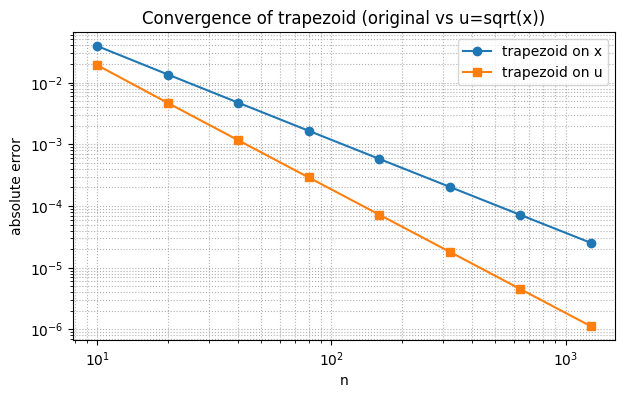

In [22]:
ns_list = df['n'].values
errs_x = np.abs(df['err_x'].values)
errs_u = np.abs(df['err_u'].values)

plt.figure(figsize=(7,4))
plt.loglog(ns_list, errs_x, '-o', label='trapezoid on x')
plt.loglog(ns_list, errs_u, '-s', label='trapezoid on u')
plt.xlabel('n'); plt.ylabel('absolute error'); plt.grid(True, which='both', ls=':')
plt.legend(); plt.title('Convergence of trapezoid (original vs u=sqrt(x))'); plt.show()

**Problem 5.1.6**

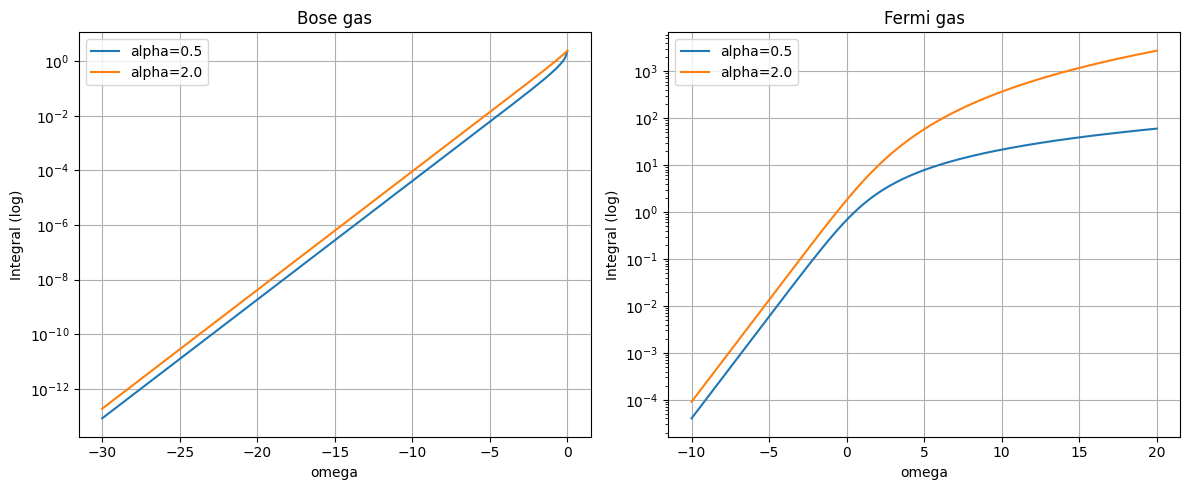

In [23]:
def integrand(x, alpha, omega, kind):
    if kind == 'fermion':
        denom = np.exp(x - omega) + 1.0
    else:
        denom = np.exp(x - omega) - 1.0
        denom = np.where(np.abs(denom) < 1e-300, 1e-300, denom)
    return x**alpha / denom

def gauss_legendre_integral(func, a, b, N=200, **kwargs):
    x, w = np.polynomial.legendre.leggauss(N)
    xp = 0.5*(b-a)*x + 0.5*(b+a)
    wp = 0.5*(b-a)*w
    return np.sum(wp * func(xp, **kwargs))

alpha_list = [0.5, 2.0]
xmax = 200.0
N_quad = 300
omega_boson = np.linspace(-30, 0, 200)
omega_fermion = np.linspace(-10, 20, 200)

I_bos = {a:[] for a in alpha_list}
I_ferm = {a:[] for a in alpha_list}

for a in alpha_list:
    for w in omega_boson:
        val = gauss_legendre_integral(integrand, 0.0, xmax, N=N_quad, alpha=a, omega=w, kind='boson')
        I_bos[a].append(val)
    for w in omega_fermion:
        val = gauss_legendre_integral(integrand, 0.0, xmax, N=N_quad, alpha=a, omega=w, kind='fermion')
        I_ferm[a].append(val)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for a in alpha_list:
    plt.semilogy(omega_boson, I_bos[a], label=f'alpha={a}')
plt.xlabel('omega'); plt.ylabel('Integral (log)'); plt.title('Bose gas'); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
for a in alpha_list:
    plt.semilogy(omega_fermion, I_ferm[a], label=f'alpha={a}')
plt.xlabel('omega'); plt.ylabel('Integral (log)'); plt.title('Fermi gas'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

**Problem 5.2.1**

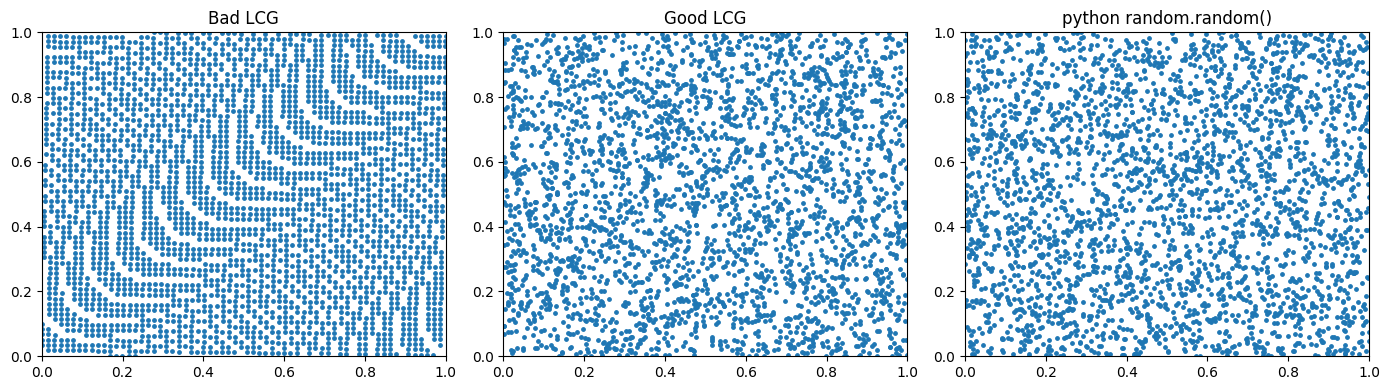

In [24]:
def bad_lcg(n, x0=1):
    a = 65; c = 17; m = 4096
    xs = np.zeros(n); x = x0
    for i in range(n):
        x = (a*x + c) % m; xs[i] = x/m
    return xs

def good_lcg(n, x0=1):
    a = 1103515245; c = 12345; m = 2**31
    xs = np.zeros(n); x = x0
    for i in range(n):
        x = (a*x + c) % m; xs[i] = x/m
    return xs

N = 3000
bad = bad_lcg(N); good = good_lcg(N); py = np.array([random.random() for _ in range(N)])
fig, axs = plt.subplots(1,3,figsize=(14,4))
axs[0].scatter(bad[:-1], bad[1:], s=6); axs[0].set_title('Bad LCG'); axs[0].set_xlim(0,1); axs[0].set_ylim(0,1)
axs[1].scatter(good[:-1], good[1:], s=6); axs[1].set_title('Good LCG'); axs[1].set_xlim(0,1); axs[1].set_ylim(0,1)
axs[2].scatter(py[:-1], py[1:], s=6); axs[2].set_title('python random.random()'); axs[2].set_xlim(0,1); axs[2].set_ylim(0,1)
plt.tight_layout(); plt.show()

**Problem 5.2.2**

In [25]:
def chi2_test(generator_func, n=100000, nb=10):
    samples = generator_func(n)
    bins = np.linspace(0,1,nb+1)
    counts, _ = np.histogram(samples, bins=bins)
    expected = n/nb
    chi2 = np.sum(((counts - expected)**2)/expected)
    return chi2, counts

def gen_bad(n): return bad_lcg(n)
def gen_good(n): return good_lcg(n)
def gen_py(n): return np.array([random.random() for _ in range(n)])

for name, gen in [('bad', gen_bad), ('good', gen_good), ('py', gen_py)]:
    chi2, counts = chi2_test(gen, n=100000, nb=10)
    print(name, "chi2=", chi2, " (expected dof = 9)")

bad chi2= 0.1486  (expected dof = 9)
good chi2= 8.255799999999999  (expected dof = 9)
py chi2= 3.372  (expected dof = 9)


**Problem 5.2.3**

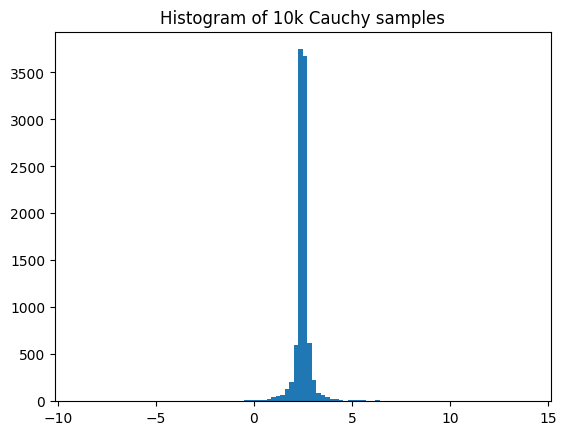

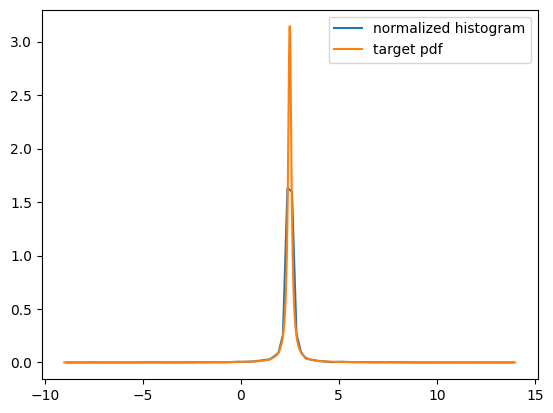

n= 1000 mean_cauchy= 2.369859972547839 mean_normal= 2.5005100641838363
n= 10000 mean_cauchy= 2.8777037842023216 mean_normal= 2.5015048496413894
n= 100000 mean_cauchy= 2.4361260771471263 mean_normal= 2.499505330470333
n= 1000000 mean_cauchy= 2.4942165358517294 mean_normal= 2.500024100790484


In [ ]:
x0 = 2.5; gamma = 0.1
def cauchy_icdf(u):
    return x0 + gamma * np.tan(np.pi*(u - 0.5))

def cauchy_pdf(x):
    return 1.0 / (10.0 * np.pi * ((x-2.5)**2 + 0.01))

n_samples = 10000
us = np.random.random(n_samples)
xs = cauchy_icdf(us)
plt.hist(xs, bins=100, range=(-9,14)); plt.title('Histogram of 10k Cauchy samples'); plt.show()

counts, edges = np.histogram(xs, bins=100, range=(-9,14))
bin_centers = 0.5*(edges[:-1] + edges[1:]); bin_width = edges[1]-edges[0]
plt.plot(bin_centers, counts/(n_samples*bin_width), label='normalized histogram')
xx = np.linspace(-9,14,1000); plt.plot(xx, cauchy_pdf(xx), label='target pdf'); plt.legend(); plt.show()

def sample_means(ns):
    means_cauchy = []; means_normal = []
    for n in ns:
        us = np.random.random(n); xs = cauchy_icdf(us); means_cauchy.append(np.mean(xs))
        normals = np.random.normal(loc=2.5, scale=0.1, size=n); means_normal.append(np.mean(normals))
    return means_cauchy, means_normal

ns = [10**3, 10**4, 10**5, 10**6]
mc, mn = sample_means(ns)
for n, m1, m2 in zip(ns, mc, mn):
    print('n=', n, 'mean_cauchy=', m1, 'mean_normal=', m2)

**Problem 5.2.4**

In [ ]:
def metropolis_exp_sampler(n_steps=200000, burn=2000, step_scale=1.0):
    x = 1.0
    samples = []
    for i in range(n_steps):
        prop = x + random.gauss(0, step_scale)
        if prop <= 0:
            samples.append(x); continue
        a = math.exp(-(prop - x))
        if random.random() < a:
            x = prop
        samples.append(x)
    return np.array(samples[burn::100])

samples = metropolis_exp_sampler(n_steps=200000, burn=2000, step_scale=1.0)
f_vals = samples**2
est = np.mean(f_vals); stderr = np.std(f_vals)/math.sqrt(len(f_vals))
print("Metropolis estimate =", est, "+/-", stderr, "(exact = 2.0)")

xn, wn = laggauss(2)
I_gl = np.sum(wn * (xn**2))
print("Gauss-Laguerre n=2 estimate =", I_gl, "Exact = 2.0")

Metropolis estimate = 1.8773373289675865 +/- 0.08573489591452535 (exact = 2.0)
Gauss-Laguerre n=2 estimate = 2.0 Exact = 2.0
